In [1]:
import json 
import numpy as np 
from tqdm import tqdm 
from pathlib import Path
from collections import defaultdict

def get_prediction(prob_dict_list):
    predicted_toks_and_probs = []
    for timestep, prob_dict in enumerate(prob_dict_list): 
        toks, probs = zip(*prob_dict.items())
        # print(prob_dict['SourceCopy'])
        best_prob_idx = np.argmax(probs)
        best_prob, best_tok = probs[best_prob_idx], toks[best_prob_idx]
        predicted_toks_and_probs.append((best_tok, best_prob))
    return predicted_toks_and_probs

def check_tokens(pred_tok, tgt_tok, prev_tgts):
    if "SourceCopy" not in pred_tok and "TargetCopy" not in pred_tok:
        return pred_tok == tgt_tok
    elif "SourceCopy" in pred_tok:
        return pred_tok.split("_")[1] == tgt_tok
    else:
        try:
            tok_idx = int(pred_tok.split("_")[1])-1
            return prev_tgts[tok_idx] == tgt_tok
        except IndexError:
            print(len(prev_tgts))
            print(pred_tok)
            print(prev_tgts)
            raise AssertionError
    

def read_json(path): 
    print(f"opening data")
    with open(path) as f1:
        data = json.load(f1)
    print(f"got data")
    return data

def get_probs(data):
    probs_to_ret = defaultdict(list)
    func_ontology = set()

    mistakes, corrects = [], []

    for instance_idx, instance in tqdm(enumerate(data)): 
        instance = instance
        left_context = [x[0] for x in instance['left_context']][1:]
        target_toks = left_context + ["@end@"]
        probs = instance['prob_dist']
        predicted_toks = get_prediction(probs)

        source_tokens = " ".join([x[0] for x in instance['source_tokens']])
        for i in range(len(left_context)):
            input_token = left_context[i]
            output_token = predicted_toks[i][0]
            output_prob = predicted_toks[i][1]
            target_token = target_toks[i]
            tokens_are_equal = check_tokens(output_token, target_token, left_context[:i])
            if not tokens_are_equal:
                mistake = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks[0:i],
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "target_token": target_token}
                mistakes.append(mistake)
            else:
                correct = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks[0:i],
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "target_token": target_token}
                corrects.append(correct)

    return mistakes, corrects

In [2]:
data = read_json("/brtx/604-nvme2/estengel/miso_models/tune_roberta//translate_output/dev_valid_losses.json")

opening data
got data


In [29]:
mistakes, corrects = get_probs(data)

6815it [01:17, 87.80it/s] 


In [30]:
from collections import Counter
print(len(mistakes))
print(len(corrects))

mistake_examples = len(set([x['instance_idx'] for x in mistakes])) 
correct_examples = len(set([x['instance_idx'] for x in corrects]))

mistake_idxs = [x['instance_idx'] for x in mistakes]
mistake_counter = Counter(mistake_idxs)
mistake_only_once = [x for x in mistake_counter if mistake_counter[x] == 1]
print(f"{len(mistake_only_once)} of {mistake_examples} ({len(mistake_only_once)/mistake_examples*100:.2f}%) examples have one mistake only")
print(f"number of unique failures: {len(mistakes)}")
print("number of failure examples: " +  str(mistake_examples))
print("number of correct examples: " +  str(correct_examples)) 

print(f"accuracy: {correct_examples/(correct_examples+mistake_examples)}")

print(f"mistakes per mistake example: {len(mistakes)/mistake_examples}")


1908
89881
920 of 1264 (72.78%) examples have one mistake only
number of unique failures: 1908
number of failure examples: 1264
number of correct examples: 6815
accuracy: 0.8435449931922268
mistakes per mistake example: 1.509493670886076


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 



In [32]:
mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]


print(np.mean(mistake_probs))
print(np.mean(correct_probs))

# prob_df = pd.DataFrame(columns=['prob', 'correct'])
prob_df_data = []
for prob in mistake_probs:
    prob_df_data.append({'prob': prob, 'correct': False}) 
for prob in correct_probs:
    prob_df_data.append({'prob': prob, 'correct': True}) 


prob_df = pd.DataFrame(prob_df_data)





0.7746575518708434
0.992833662465505


In [33]:
import scipy 
from collections import Counter

values, bin_edges, bin_number = scipy.stats.binned_statistic(prob_df['prob'], 
                                                             prob_df['correct'], 
                                                             statistic='mean', 
                                                             bins=20)
bin_lookup = Counter(bin_number)

    prob_model  prob_correct  count  log_count
0     0.043063      0.040000    NaN   3.218876
1     0.090910      0.000000    NaN   3.135494
2     0.138756      0.052632    NaN   2.944439
3     0.186603      0.190476    NaN   3.044522
4     0.234450      0.176471    NaN   2.833213
5     0.282297      0.357143    NaN   3.332205
6     0.330143      0.388889    NaN   3.583519
7     0.377990      0.333333    NaN   3.871201
8     0.425837      0.361111    NaN   4.276666
9     0.473683      0.435115    NaN   4.875197
10    0.521530      0.460094    NaN   5.361292
11    0.569377      0.566845    NaN   5.231109
12    0.617224      0.618785    NaN   5.198497
13    0.665070      0.562771    NaN   5.442418
14    0.712917      0.657993    NaN   5.594711
15    0.760764      0.702341    NaN   5.700444
16    0.808611      0.673797    NaN   5.924256
17    0.856457      0.814941    NaN   6.378426
18    0.904304      0.845893    NaN   7.074117
19    0.952151      0.992487    NaN  11.383329


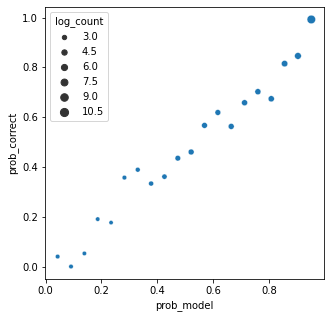

In [59]:
fig, ax = plt.subplots(figsize=(5,5))

df_to_plot = pd.DataFrame(columns=["prob_model", "prob_correct", "count"])
for i, (val, edge, bin_num) in enumerate(zip(values, bin_edges, bin_number)):
    df_to_plot = df_to_plot.append({"prob_model": edge, 
                                    "prob_correct": val, 
                                    "log_count": np.log(bin_lookup[i+1])}, 
                                    ignore_index=True)


sns.scatterplot(data=df_to_plot, x = "prob_model", y="prob_correct", size="log_count", ax=ax, legend='brief')

print(df_to_plot)

In [9]:
np.random.seed(12)
# inspect mistakes 
# sample 10 from across the range of mistakes
n_bins = 20
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i]
    if len(bin_mistakes) == 0:
        print(i)
        print(bin_number[0:10])

    mistake = np.random.choice(bin_mistakes, size=1)[0]

    print(mistake['source_tokens'])
    print(mistake['left_context'])
    print(mistake['target_toks'])
    print(mistake['output_token'])
    print(mistake['output_prob'])
    print(mistake['target_token'])
    print("")


__User When is Chrissy 's wedding ?
['@ROOT@', 'Yield', 'Event.start', 'singleton', 'QueryEventResponse.results', 'FindEventWrapperWithDefaults', 'Event.subject_?', '?~=', 'String']
['@ROOT@', 'Yield', 'Event.start', 'singleton', 'QueryEventResponse.results', 'FindEventWrapperWithDefaults', 'Event.subject_?', '?~=', 'String']
Maddy's
0.044383853673934937
Chrissy's

__User Great . Thank you . __Agent Let me know if there 's anything else I can help you with . __User Schedule City Tour for 1 pm on Friday at St. Augustine , FL .
['@ROOT@', 'Yield', 'CreateCommitEventWrapper', 'CreatePreflightEventWrapper', '&', 'Event.location_?', '?=', 'LocationKeyphrase.apply', 'String', 'St.']
['@ROOT@', 'Yield', 'CreateCommitEventWrapper', 'CreatePreflightEventWrapper', '&', 'Event.location_?', '?=', 'LocationKeyphrase.apply', 'String', 'St.']
Angeles,
0.11870268732309341
Augustine,

__User Yeah , that works . __Agent I 've put that on your calendar . Your status is set to Out of Office . __User Aweso

In [10]:
import scipy
from scipy import stats
np.random.seed(12)
# lets look at inputs for 100 mistakes 
n_bins = 100
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i and mistake_counter[x['instance_idx']] == 1]
    if len(bin_mistakes) == 0:
        continue
    mistake = np.random.choice(bin_mistakes, size=1)[0]
    utt = mistake['source_tokens'].split("__User")[-1]
    print(f"{utt}, {mistake['output_token']}, {mistake['target_token']}, {mistake['output_prob']:.3f}")

 When is Chrissy 's wedding ?, Maddy's, Chrissy's, 0.044
 Please tell me the date of the event called Pamela 's baby shower, Martha's, Pamela's, 0.054
 Does Tiwa 's Kitchen Restaurant in Taos have a full bar, Ruth's, Tiwa, 0.063
 What 's the average price of a meal at Bobbi 's in Jacksonville ., Taylor's, Bobbi's, 0.072
 What is the five day forecast for Brunswick , ME, Stehekin,, Brunswick,, 0.088
 Please add the following event : Martha 's birthday party , January 5 th , 2019 at 5 : 00 p.m. , Lake Restaurant ., Sarah's, Martha's, 0.094
 What is the weather going to be like tomorrow morning in Woodbridge , VA ?, Amherst,, Woodbridge,, 0.106
 Add amy 's birthday party on april 24 th at 3 pm last year, Susie's, amy's, 0.110
 Okay . I will travel to Gatlinburg , TN on November 10 th . What will the weather be like, Amherst,, Gatlinburg,, 0.123
 I need an event from April 29 th for Amy 's birthday, Sarah's, Amy's, 0.137
 Yep , but I want the location to be En - Joie Golf Club in Endicott,

(0.995, 1.0)

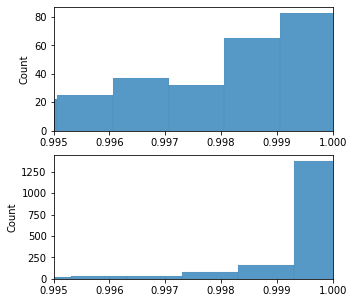

In [61]:
# What percentage of mistakes are low probability? 
# What percentage of correct are high probability? 

mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]
correct_probs = np.random.choice(correct_probs, size = len(mistake_probs), replace=False)
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=False, sharey=False)
sns.histplot(mistake_probs, ax=ax[0], binwidth=0.001)
sns.histplot(correct_probs, ax=ax[1], binwidth=0.001)
ax[0].set_xlim(0.995, 1.0)
ax[1].set_xlim(0.995, 1.0)



In [65]:
# what's the optimal threshold? 

def compute_f1(df, thresh):
    mistakes = df[df['prob'] < thresh]
    corrects = df[df['prob'] >= thresh]
    false_negatives = len(mistakes[mistakes['correct'] == True])
    false_positives = len(corrects[corrects['correct'] == False])
    true_positives = len(corrects[corrects['correct'] == True])
    try:
        precision = true_positives/(true_positives + false_positives)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = true_positives/(true_positives + false_negatives)
    except ZeroDivisionError:
        recall = 0
    try:
        f1 = 2*precision*recall/(precision + recall)
    except ZeroDivisionError:
        f1 = 0
    
    return [f1, precision, recall]

threshes = np.arange(0.995, 1.0, 0.0001)
f1s = [[thresh] + compute_f1(prob_df, thresh) for thresh in threshes]

best_thresh, *best_f1 = max(f1s, key=lambda x: x[1])
print(best_thresh, best_f1)

# so anything less than 0.995 confidence can safely be said to be a mistake, with 0.94 F1 (pretty good), super high precision, lower recall 

0.995 [0.9430377520025333, 0.9969870928545745, 0.8946273405947864]
